<h1><center>Project Stage - IV (Basic Machine Learning)</center></h1>

In [1]:
# Loading libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# For visvalization
import matplotlib.pyplot as plt
# import seaborn as sns
import seaborn as sns

# Plotting using plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# For creating widgets
from ipywidgets import widgets, interact
from IPython.display import display

In [2]:
import os
os.chdir(r'C:\Users\manog\OneDrive\Desktop\Data Science')

In [37]:
# Reading the files
df_cases = pd.read_csv('covid_confirmed_usafacts.csv')
df_deaths = pd.read_csv('covid_deaths_usafacts.csv')

In [4]:
# County wise population
df_population = pd.read_csv('covid_county_population_usafacts.csv')
df_population.head()

,countyFIPS,County Name,State,population
0,0,Statewide Unallocated,AL,0
1,1001,Autauga County,AL,55869
2,1003,Baldwin County,AL,223234
3,1005,Barbour County,AL,24686
4,1007,Bibb County,AL,22394


# Data Prepration

In [5]:
df_cases_modified = df_cases.melt(id_vars=['countyFIPS', 'County Name', 'State', 'StateFIPS'],
                                  var_name="Date",
                                  value_name="Cases")

df_deaths_modified = df_deaths.melt(id_vars=['countyFIPS', 'County Name', 'State', 'StateFIPS'],
                                    var_name="Date",
                                    value_name="Deaths")

In [6]:
# Modifying the data for the 2nd half of 2022
df_cases_modified['Date'] = pd.to_datetime(df_cases_modified['Date'])
df_cases_modified = df_cases_modified[(df_cases_modified['Date']>"6/1/2022") & (df_cases_modified['Date']<"12/31/2022")]

df_deaths_modified['Date'] = pd.to_datetime(df_deaths_modified['Date'])
df_deaths_modified = df_deaths_modified[(df_deaths_modified['Date']>"6/1/2022") & (df_deaths_modified['Date']<"12/31/2022")]

In [7]:
# Saving a copy
df_cases_modified_copy = df_cases_modified.copy()

In [8]:
# Selecting a state - 'TX'
df_cases_modified = df_cases_modified[df_cases_modified['State']=='TX']
df_deaths_modified = df_deaths_modified[df_deaths_modified['State']=='TX']

<AxesSubplot:xlabel='County Name'>

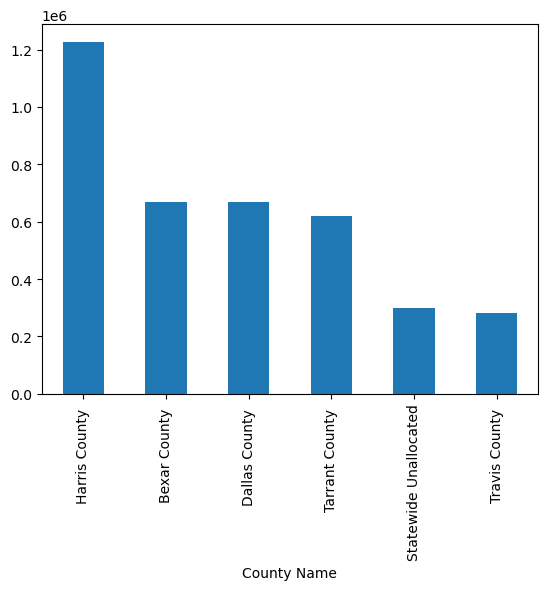

In [9]:
# Selecting top 5 counties based on number of cases
df_cases_modified.groupby(['County Name'])['Cases'].max().sort_values(ascending=False)[:6].plot(kind='bar')

In [10]:
# Filtering the data based on the top 5 counties
top_five_counties = ['Harris County ', 'Bexar County ', 'Dallas County ',
                     'Tarrant County ', 'Travis County ']

df_deaths_top5 = df_deaths_modified[df_deaths_modified['County Name'].isin(top_five_counties)]
df_cases_top5 = df_cases_modified[df_cases_modified['County Name'].isin(top_five_counties)]

In [11]:
# Merging the cases and deaths data along with population data
cols_to_use = df_cases_top5.columns.difference(df_deaths_top5.columns).to_list() + ['Date', 'County Name']
df_merged = pd.merge(df_deaths_top5, df_cases_top5[cols_to_use], on=['County Name', 'Date'])

# Removing leading and training spaces
df_merged['County Name'] = df_merged['County Name'].apply(lambda x: x.strip())

# Merging with population
df_merged = pd.merge(df_merged, df_population, on=['State', 'County Name'])

df_merged.head()

,countyFIPS_x,County Name,State,StateFIPS,Date,Deaths,Cases,countyFIPS_y,population
0,48029,Bexar County,TX,48,2022-06-02,6146,573582,48029,2003554
1,48029,Bexar County,TX,48,2022-06-03,6146,574304,48029,2003554
2,48029,Bexar County,TX,48,2022-06-04,6149,574974,48029,2003554
3,48029,Bexar County,TX,48,2022-06-05,6149,575487,48029,2003554
4,48029,Bexar County,TX,48,2022-06-06,6153,575980,48029,2003554


In [12]:
# Removing unecessary or duplicate information columns and renaming others
columns_to_remove = ['countyFIPS_y', 'State', 'countyFIPS_x', 'StateFIPS']
df_merged = df_merged.drop(columns=columns_to_remove)
df_merged = df_merged.rename(columns={'countyFIPS_x':'countyFIPS'})

<h1><center> Task 1 </center></h1>

In [13]:
# Extracting Day, Month and Year from the Date
df_merged['Date'] = pd.to_datetime(df_merged['Date'])
df_merged_copy = df_merged.copy()
df_merged['day'] = df_merged['Date'].dt.day
df_merged['month'] = df_merged['Date'].dt.month
# Droping year as it is same for all the present data
# df_merged['year'] = df_merged['Date'].dt.year

The features `day` and `month` are cyclic in nature. If I do not do any preprocessing on them and directly feed them to model, the model can give more or less importance based on the values. Eg. days will have values from 1 to 31, so model thinks that value 31 is more than 1, but actually they are just days so our model can go wrong. Thus, I will be performing a transformation on these features to make them cyclic.

<center><img src = "https://www.math.hkust.edu.hk/~machiang/1013/Notes/sine_2.gif"></center>

In [14]:
# months and days in a cyclic continuous feature.
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

df_merged = encode(df_merged, 'month', 6)
df_merged = encode(df_merged, 'day', 31)

In [15]:
# Normalizing the year and population column
# def normalize_data(df, col):
#     normalized_df = (df[col]-df[col].min())/(df[col].max()-df[col].min())
#     return normalized_df
    
# df_merged['year'] = normalize_data(df_merged, 'year')

# Removing unecessary or duplicate information columns
df_merged = df_merged.drop(columns=['day', 'month', 'Date'])

##  Linear and Non-Linear (polynomial) regression models

In [16]:
# 5 models for top 5 counties
# Statewide Unallocated County which is not a countie so not considering it
df_harris = df_merged[df_merged['County Name']=='Harris County']
df_bexar = df_merged[df_merged['County Name']=='Bexar County']
df_dallas = df_merged[df_merged['County Name']=='Dallas County']
df_tarrant = df_merged[df_merged['County Name']=='Tarrant County']
df_travis = df_merged[df_merged['County Name']=='Travis County']


In [17]:
# Linear Model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


def create_linear_model(data, name=None):
    lr = LinearRegression() #RandomForestRegressor(max_depth=3, min_samples_leaf=50)
    data_fn = data.copy()
    
    # Cumulative to normal values
    data_fn['Cases'] = data_fn['Cases'].diff().fillna(0)
    data_fn['Deaths'] = data_fn['Deaths'].diff().fillna(0)
    
    # From start of infection
    start_of_infection = data_fn[data_fn['Cases']>0].index[0]
    data_fn = data_fn.loc[start_of_infection:, :]
    data_fn.reset_index(drop=True, inplace=True)
    
    X = data_fn.drop(columns=['County Name', 'population', 'Deaths'])
    y = data_fn['Deaths']
    
    # Fitting the model
    lr.fit(X, y)
    
    # Prediction
    y_predict = lr.predict(X)
    data_fn['prediction'] = y_predict
    
    # RMSE
    rmse = mean_squared_error(y, y_predict)**0.5
    print(f"The RMSE for {name} county is {rmse}")
    
    return data_fn

In [18]:
# RMSE for top 5 counties
df1 = create_linear_model(df_harris, 'Harris County')
df2 = create_linear_model(df_bexar, 'Bexar County')
df3 = create_linear_model(df_dallas, 'Dallas County')
df4 = create_linear_model(df_tarrant, 'Tarrant County')
df5 = create_linear_model(df_travis, 'Travis County')


The RMSE for Harris County county is 2.9558204441911546
The RMSE for Bexar County county is 1.9807025618971916
The RMSE for Dallas County county is 1.522824329172117
The RMSE for Tarrant County county is 1.590593273543241
The RMSE for Travis County county is 0.7607077342890752


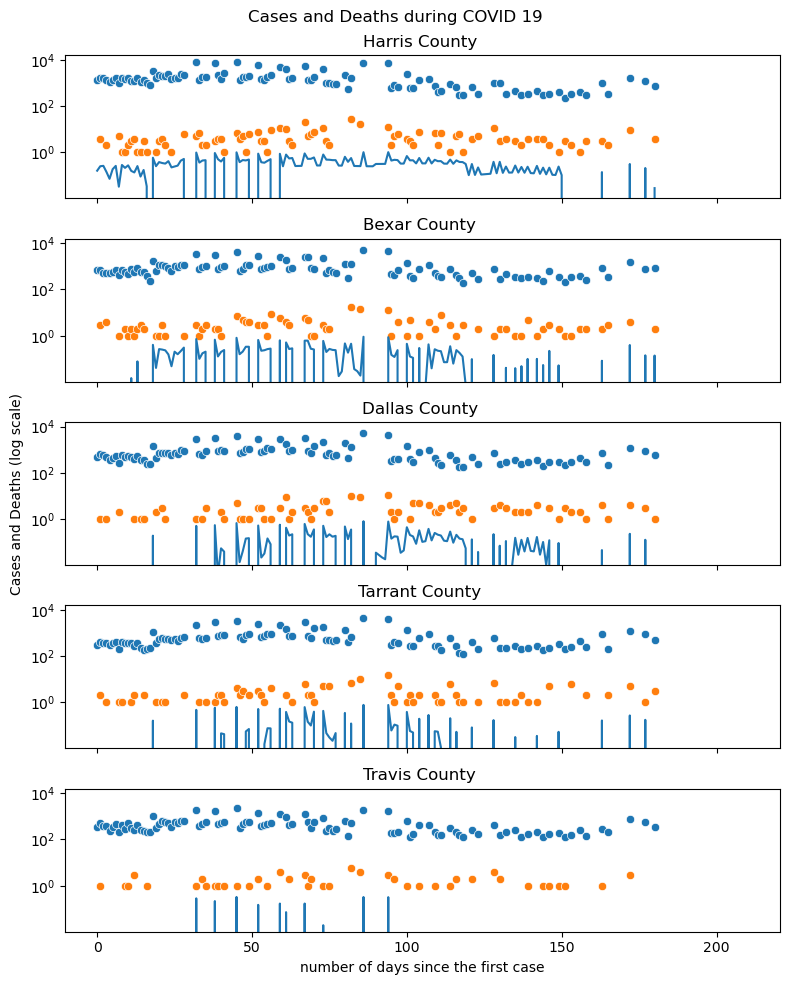

In [19]:
# Plotting data
fig, axis = plt.subplots(5, 1, figsize=(8, 10), sharey=True, sharex=True)
df_list = [df1, df2, df3, df4, df5]
i = 0
top_five_counties = ['Harris County ', 'Bexar County ', 'Dallas County ',
                     'Tarrant County ', 'Travis County ']
for data_frame, ax, name in zip(df_list, axis.ravel(), top_five_counties):
  ax.set(yscale="log")
  sns.scatterplot(x=data_frame.index, y=data_frame['Cases'], ax=ax, legend='brief')
  sns.scatterplot(x=data_frame.index, y=data_frame['Deaths'], ax=ax)
  sns.lineplot(x=data_frame.index, y=data_frame['prediction'], ax=ax)
  ax.set_title(name)
  ax.set_ylabel("")
  if i == 2: 
    ax.set_ylabel("Cases and Deaths (log scale)")
  else: ax.set_ylabel("")
  ax.set_xlabel("number of days since the first case")
  i+=1

fig.suptitle("Cases and Deaths during COVID 19")
plt.tight_layout()
plt.show()

For all the top 5 counties in TX, the trend of cases and deaths is similar. It has got peaks after around 90 days of the first case from 1st June 2022.

##  Identify which counties are most at risk.

In [20]:
df_merged_copy['per_capita_cases'] = df_merged_copy['Cases']*100000/df_merged_copy['population']
df_merged_copy['per_capita_deaths'] = df_merged_copy['Deaths']*100000/df_merged_copy['population']

In [21]:
df_merged_copy.head()

,County Name,Date,Deaths,Cases,population,per_capita_cases,per_capita_deaths
0,Bexar County,2022-06-02,6146,573582,2003554,28628.227639,306.754897
1,Bexar County,2022-06-03,6146,574304,2003554,28664.263604,306.754897
2,Bexar County,2022-06-04,6149,574974,2003554,28697.704180,306.904630
3,Bexar County,2022-06-05,6149,575487,2003554,28723.308680,306.904630
4,Bexar County,2022-06-06,6153,575980,2003554,28747.914955,307.104276


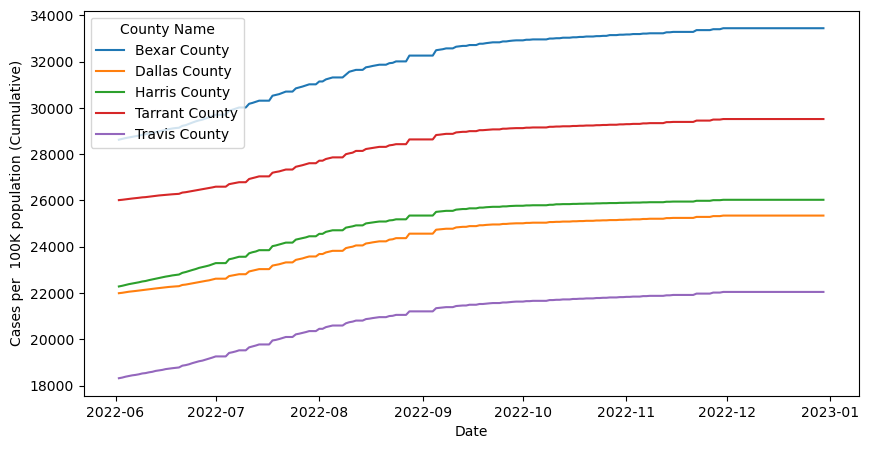

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(data=df_merged_copy, x='Date', y='per_capita_cases', hue='County Name', ax=ax)
ax.set_ylabel("Cases per  100K population (Cumulative)");

For Bexar county, the cases are rising faster than others. Specially in July-2022 to Sept-2022, the rise in COVID cases were highest (which is true for all other counties as well).

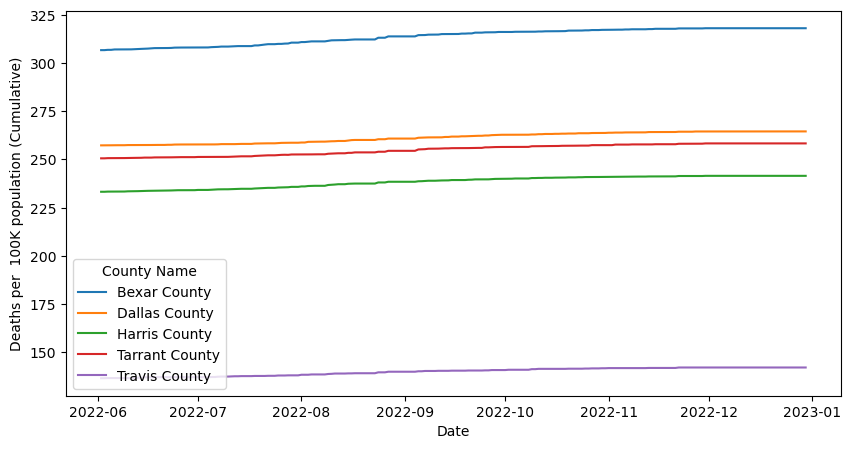

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(data=df_merged_copy, x='Date', y='per_capita_deaths', hue='County Name', ax=ax)
ax.set_ylabel("Deaths per  100K population (Cumulative)");

The deaths per 100K population is almost constant except Bexar county which is a concern as deaths other counties are very less compared to Bexar

## Hypothesis Testing

In [27]:
# Loading employment data
employment_data = pd.read_csv('EmployementEnrichment.csv')
employment_data.head()

,Area\nCode,St,Cnty,Own,NAICS,Year,Qtr,Area Type,St Name,Area,...,Industry,Status Code,Establishment Count,January Employment,February Employment,March Employment,Total Quarterly Wages,Average Weekly Wage,Employment Location Quotient Relative to U.S.,Total Wage Location Quotient Relative to U.S.
0,US000,US,0.0,0,10,2022,1,Nation,NaN,U.S. TOTAL,...,"10 Total, all industries",NaN,"11,294,919","145,582,488","147,172,213","147,781,400","2,622,652,420,011","1,374",1.0,1.0
1,US000,US,0.0,1,10,2022,1,Nation,NaN,U.S. TOTAL,...,"10 Total, all industries",NaN,"60,882","2,860,360","2,858,451","2,853,067","60,805,753,244","1,637",1.0,1.0
2,US000,US,0.0,2,10,2022,1,Nation,NaN,U.S. TOTAL,...,"10 Total, all industries",NaN,"70,526","4,456,377","4,529,802","4,534,064","78,903,410,196","1,347",1.0,1.0
3,US000,US,0.0,3,10,2022,1,Nation,NaN,U.S. TOTAL,...,"10 Total, all industries",NaN,"171,395","13,954,426","14,065,705","14,114,268","203,425,519,443","1,114",1.0,1.0
4,US000,US,0.0,5,10,2022,1,Nation,NaN,U.S. TOTAL,...,"10 Total, all industries",NaN,"10,992,116","124,311,325","125,718,255","126,280,001","2,279,517,737,128","1,398",1.0,1.0


In [28]:
# Hypothesis 1: Higher Employment leads to lower COVID cases as the spread is lower.
condition = ((df_cases_modified['Date']>="2022-6-1") & ((df_cases_modified['Date']<="2022-12-31")))
cases = df_cases_modified[condition]['Cases'].values

# Merging Jan, Feb and March employemnt
employment = employment_data[['January Employment', 'February Employment', 'March Employment']].apply(lambda x : x.str.replace(',', '').astype(float)).values
# Flattening data
employment = np.reshape(employment, (-1, 1))

# Print the variance of both data groups
print(np.var(employment)/np.var(cases))

76.42421821967889


As the variance ratio is > 4:1, the Welch’s t-test will be conducted by not taking into consideration the equal population variances.

In [29]:
import scipy.stats as stats

# Performing the two sample t-test with unequal variances
stats.ttest_ind(a=employment, b=cases, equal_var=False)

Ttest_indResult(statistic=array([1.51309677]), pvalue=array([0.13025662]))

p-value is > 0.05 (significance value), so the null hypothesis can't be rejected. Thus, higher Employment does lead to lower COVID cases.

In [30]:
# Hypothesis 2: Higher weekly wages might lead to lower COVID cases as people can spend
# more on immunity build up or take better precautionary measure in controlling COVID.

weekly_wages = employment_data['Average Weekly Wage'].str.replace(',', '').astype(float).values
# Print the variance of both data groups
print(np.var(cases)/np.var(weekly_wages))

42181.86466729231


In [31]:
# Performing the two sample t-test with unequal variances
stats.ttest_ind(a=cases, b=weekly_wages, equal_var=False)

Ttest_indResult(statistic=63.60272393583431, pvalue=0.0)

p-value is < 0.05 (significance value), so the null hypothesis can be rejected. Thus higher weekly wages might not lead to lower COVID cases.

<h1><center> Task 2 </center></h1>

In [32]:
# Confidance Interval
from statistics import NormalDist

def confidence_interval(data, confidence=0.95):
  dist = NormalDist.from_samples(data)
  z = NormalDist().inv_cdf((1 + confidence) / 2.)
  h = dist.stdev * z / ((len(data) - 1) ** .5)
  return dist.mean - h, dist.mean + h

In [35]:
def plot_results(data, name=None):
  fig = go.Figure()
  x = data.index.values
  CI = confidence_interval(data['prediction'], 0.95)
  
  fig.add_trace(go.Scatter(x=x, y=data['Deaths'],
                      mode='markers',
                      name='Deaths'))
  
  fig.add_traces(go.Scatter(x=x, y = data['prediction'],
                           mode='markers+lines',
                            name='prediction'))
  
  fig.add_traces([go.Scatter(x=x, y = data['prediction']+CI[1],
                           mode = 'lines', line_color = 'rgba(0,0,0,0)',
                           showlegend = False),
                go.Scatter(x=x, y = data['prediction']-CI[0],
                           mode = 'lines', line_color = 'rgba(0,0,0,0)',
                           name = '95% confidence interval',
                           fill='tonexty', fillcolor = 'rgba(255, 0, 0, 0.2)')])

  fig.update_yaxes(title_text="No. of deaths")
  fig.update_xaxes(title_text="number of days since the first case")
  fig.update_layout(
      title=dict(text=f"Analysis for {name}") 
  )

  fig.show()

In [36]:
plot_results(df1, 'Harris County')